# U-Net: Convolutional Networks for Biomedical Image Segmentation  
# Nucleus detection using U-Net
Part of Kaggle's 2018 Data Sciene Bowl
- https://www.kaggle.com/c/data-science-bowl-2018

#### Spot Nuclei. Speed Cures.

Imagine speeding up research for almost every disease, from lung cancer and heart disease to rare disorders. The 2018 Data Science Bowl offers our most ambitious mission yet: create an algorithm to automate nucleus detection.

We’ve all seen people suffer from diseases like cancer, heart disease, chronic obstructive pulmonary disease, Alzheimer’s, and diabetes. Many have seen their loved ones pass away. Think how many lives would be transformed if cures came faster.

By automating nucleus detection, you could help unlock cures faster—from rare disorders to the common cold. Want a snapshot about the 2018 Data Science Bowl? [View this video.](https://www.youtube.com/watch?v=eHwkfhmJexs&feature=youtu.be)

- Alot of the work in this notework was provided by Kjetil Åmdal-SævikKeras who made the "U-Net starter - LB 0.277" the top rated Kernel on Kaggle.
- https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

## U-Net model

![Alt Text](img/u-net.jpg)

# The network architecture

It consists of a contracting path (left side) and an expansive path (right side). The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each fol- lowed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64- component feature vector to the desired number of classes. In total the network has 23 convolutional layers.

# Overlap Tile Strategy
The whole image is predicted part by part as in the figure below. The yellow area in the image is predicted using the blue area. At the image boundary, image is extrapolated by mirroring.

![Alt Text](img/f1.png)

# Elastic Deformation for Data Augmentation
To increase the size of training set, data augmentation is done by randomly deformed the input image and output segmentation map.

![Alt Text](img/f2.png)

# Separation of Touching Objects
Since the touching objects are closely placed each other, they are easily merged by the network, to separate them, a weight map is applied to the output of network.

![Alt Text](img/f3.png)

In [3]:
import os
import sys
import random
import warnings #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './U_NET/train/'
TEST_PATH = './U_NET/validation/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

#### Collect our file names for training and test date

In [4]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

#### Creating our image masks of dimension 128 x 128 (black images)

In [5]:
print('Getting and resizing training images ... ')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
# Re-sizing our training images to 128 x 128
# Note sys.stdout prints info that can be cleared unlike print.
# Using TQDM allows us to create progress bars
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    # Now we take all masks associated with that image and combine them into one single mask
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    # Y_train is now our single mask associated with our image
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

# Here we resize our test images
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing training images ... 


100%|██████████| 670/670 [06:58<00:00,  1.60it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 28.06it/s]

Done!


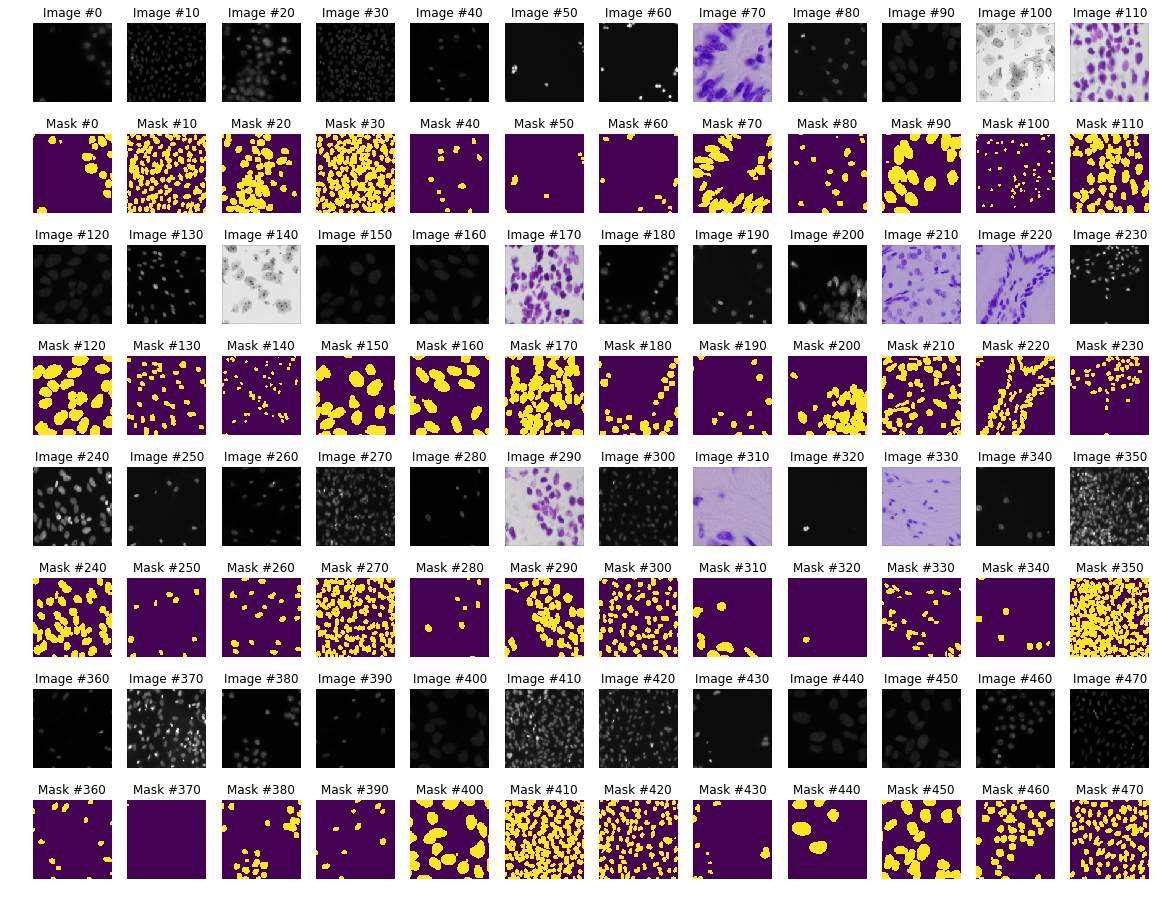

In [6]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

### We define a custom Metric called Intersection over Union (IoU)

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
# Alternative IoU function
# https://www.kaggle.com/c/data-science-bowl-2018/discussion/51553
def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X & Y|)/ (|X or Y|)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum((y_true,-1) + K.sum(y_pred,-1) - intersection)
    return (intersection + smooth) / ( union + smooth)

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

#### Another IoU Metric  
- https://www.kaggle.com/aglotero/another-iou-metric

In [9]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

### Building our U-Net Model

In [14]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# This is required so that we can re-create our U-Net Model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 128, 128, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

### Fit our model

In [17]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 124s 205ms/step - loss: 0.4591 - my_iou_metric: 0.0485 - val_loss: 0.2318 - val_my_iou_metric: 0.1556

Epoch 00001: val_loss improved from inf to 0.23180, saving model to model-dsbowl2018-1.h5
Epoch 2/50
603/603 [==============================] - 120s 200ms/step - loss: 0.2243 - my_iou_metric: 0.2051 - val_loss: 0.1574 - val_my_iou_metric: 0.2597

Epoch 00002: val_loss improved from 0.23180 to 0.15741, saving model to model-dsbowl2018-1.h5
Epoch 3/50
603/603 [==============================] - 125s 207ms/step - loss: 0.1554 - my_iou_metric: 0.3344 - val_loss: 0.1240 - val_my_iou_metric: 0.3779

Epoch 00003: val_loss improved from 0.15741 to 0.12404, saving model to model-dsbowl2018-1.h5
Epoch 4/50
603/603 [==============================] - 117s 195ms/step - loss: 0.1397 - my_iou_metric: 0.3831 - val_loss: 0.1390 - val_my_iou_metric: 0.3977

Epoch 00004: val_loss did not improve
Epoch 5/50


603/603 [==============================] - 118s 196ms/step - loss: 0.0706 - my_iou_metric: 0.5788 - val_loss: 0.0733 - val_my_iou_metric: 0.5778

Epoch 00037: val_loss did not improve
Epoch 38/50
603/603 [==============================] - 123s 205ms/step - loss: 0.0707 - my_iou_metric: 0.5759 - val_loss: 0.0762 - val_my_iou_metric: 0.5717

Epoch 00038: val_loss did not improve
Epoch 39/50
603/603 [==============================] - 128s 213ms/step - loss: 0.0716 - my_iou_metric: 0.5707 - val_loss: 0.0743 - val_my_iou_metric: 0.5710

Epoch 00039: val_loss did not improve
Epoch 40/50
603/603 [==============================] - 132s 219ms/step - loss: 0.0680 - my_iou_metric: 0.5854 - val_loss: 0.0732 - val_my_iou_metric: 0.5781

Epoch 00040: val_loss did not improve
Epoch 00040: early stopping


### Generating our predictions for training and validation data

In [18]:
# Predict on training and validation data
# Note our use of mean_iou metri
model = load_model('model-dsbowl2018-1.h5', 
                   custom_objects={'my_iou_metric': my_iou_metric})

# the first 90% was used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

# the last 10% used as validation
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

#preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

67/67 [==============================] - 4s 55ms/step


### Showing our predicted masks on our training data

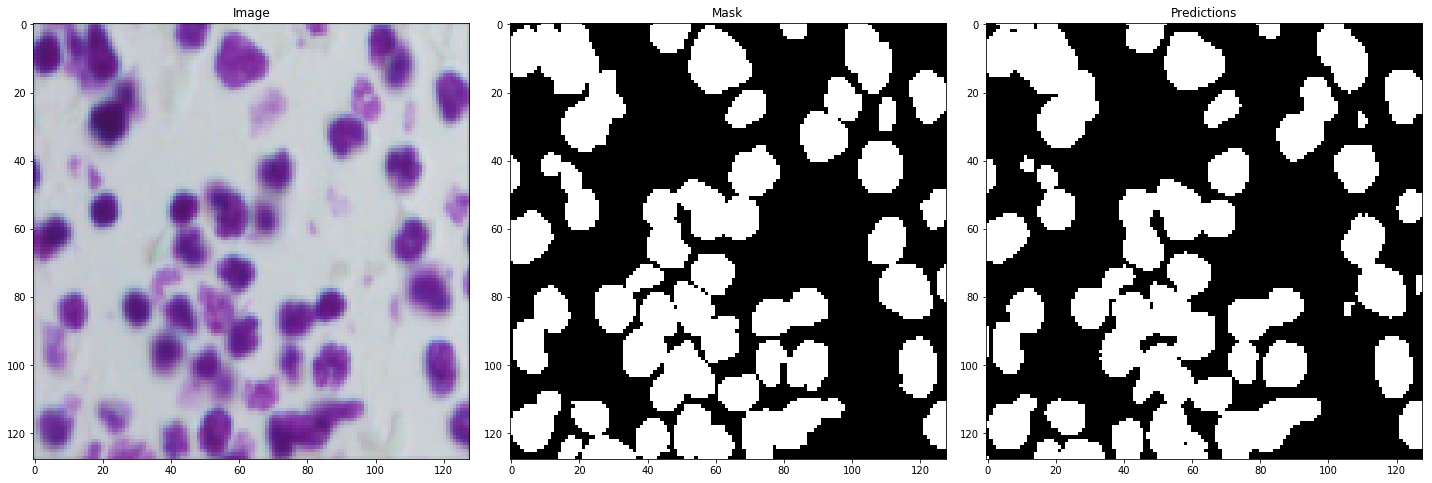

In [19]:
# Ploting our predicted masks
ix = random.randint(0, 602)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

# Our original combined mask  
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

### Showing our predicted masks on our validation data

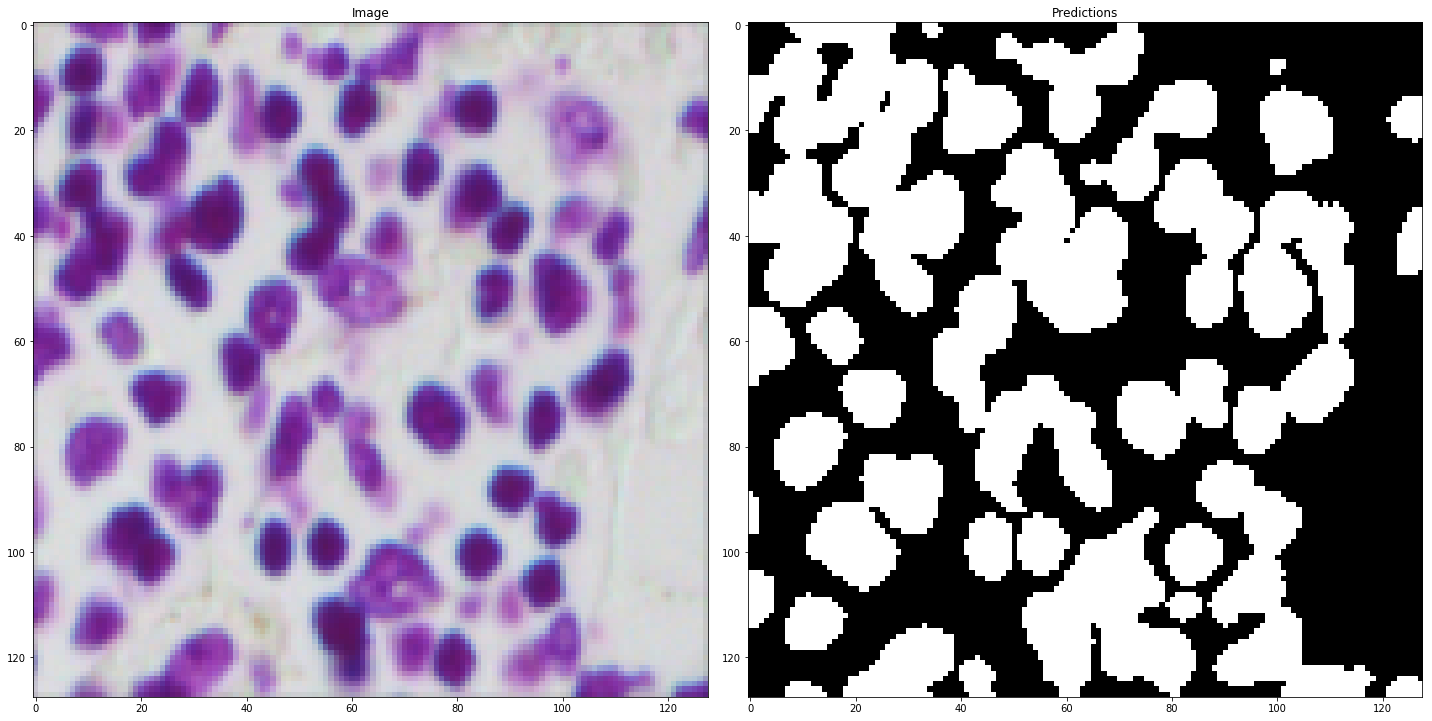

In [20]:
# Ploting our predicted masks
ix = random.randint(602, 668)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(X_train[ix])
plt.title("Image")

# The mask our U-Net model predicts
plt.subplot(122)
ix = ix - 603
imshow(np.squeeze(preds_val_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

### Generating a Classification Report

In [21]:
iou_metric(np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix]), print_table=True)

Thresh	TP	FP	FN	Prec.
0.500	18	0	3	0.857
0.550	17	1	4	0.773
0.600	17	1	4	0.773
0.650	15	3	6	0.625
0.700	13	5	8	0.500
0.750	11	7	10	0.393
0.800	10	8	11	0.345
0.850	6	12	15	0.182
0.900	3	15	18	0.083
0.950	1	17	20	0.026
AP	-	-	-	0.456


0.45567494362866406